## Exercice 2.2. - MLIM 

Outline
## I. EDA
## II. Data preparation 
## III. Feature Engineering
## IV. K-means Clustering
### IV.1. Data Preprocessing
#### IV.1.1. Check for missing values and skewness
#### IV.1.2. Manage Skewness
#### IV.1.3. Centuring and scaling the variables
### IV.2. Find optimal number of k
### IV.3. Clustering and Snake plot

Customer segmentation (i.e clustering) means sorting customers into groups based on their real or likely behavior so that a company can engage with them more effectively. For instance, a company could offer one type of promotion or discount to its most loyal customers and a different incentive to new or infrequent customers. First we need to do some EDA, data preparation and feature engineering.

## I. EDA

In [ ]:
#conda install pyarrow -c conda-forge
#!pip install pyarrow

In [275]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import datetime as dt

import sklearn.metrics
import sklearn.datasets
import sklearn.model_selection

import sklearn.cluster
import sklearn.metrics.pairwise

import warnings
warnings.filterwarnings('ignore')


In [2]:
#set your wd
%cd /Users/sophi/Desktop/MLM

C:\Users\sophi\Desktop\MLM


In [247]:
#load the data
aisles = pd.read_parquet("aisles.parquet")
dept = pd.read_parquet("departments.parquet")
pred_idx = pd.read_parquet("prediction_index.parquet")
orders = pd.read_parquet("orders.parquet")
prod = pd.read_parquet("products.parquet")
baskets = pd.read_parquet("baskets.parquet")



In [ ]:
print("Shape of aisles: ", aisles.shape)
print("Shape of departments: ", dept.shape)
print("Shape of pred_idx: ", pred_idx.shape)
print("Shape of orders: ", orders.shape)
print("Shape of products: ", prod.shape)
print("Shape of baskets: ", baskets.shape)

In [248]:
print("Variable names of aisles: ", list(aisles.columns))
print("Variable names of departments: ", list(dept.columns))
print("Variable names of pred_idx: ", list(pred_idx.columns))
print("Variable names of orders: ", list(orders.columns))
print("Variable names of products: ", list(prod.columns))
print("Variable names of baskets: ", list(baskets.columns))

Variable names of aisles:  ['aisle_id', 'aisle']
Variable names of departments:  ['department_id', 'department']
Variable names of pred_idx:  ['user_id', 'order_number']
Variable names of orders:  ['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Variable names of products:  ['product_id', 'product_name', 'aisle_id', 'department_id']
Variable names of baskets:  ['order_id', 'product_id', 'add_to_cart_order', 'reordered']


### Orders table

In [307]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.008665e+06
mean,1.710827e+06,1.029701e+05,1.719107e+01,2.776364e+00,1.344347e+01,1.070724e+01
std,9.875206e+05,5.953411e+04,1.779950e+01,2.041806e+00,4.226246e+00,8.954180e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.556832e+05,5.138500e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.711120e+06,1.026620e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.566034e+06,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


In [357]:
orders.head(n=15)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0
5,3367565,1,6,2,7,19.0
6,550135,1,7,1,9,20.0
7,3108588,1,8,1,14,14.0
8,2295261,1,9,1,16,0.0
9,2550362,1,10,4,8,30.0


In [ ]:
## if order number = 1, NAN - first order, no prior order

In [308]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214874 entries, 0 to 3214873
Data columns (total 6 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
dtypes: float64(1), int64(5)
memory usage: 147.2 MB


In [335]:
#Count orders and customers in this table
print("Unique number of orders:", len(orders.order_id.value_counts()))
print("Unique number of customers:", len(orders.user_id.value_counts()))

Unique number of orders: 3214874
Unique number of customers: 206209


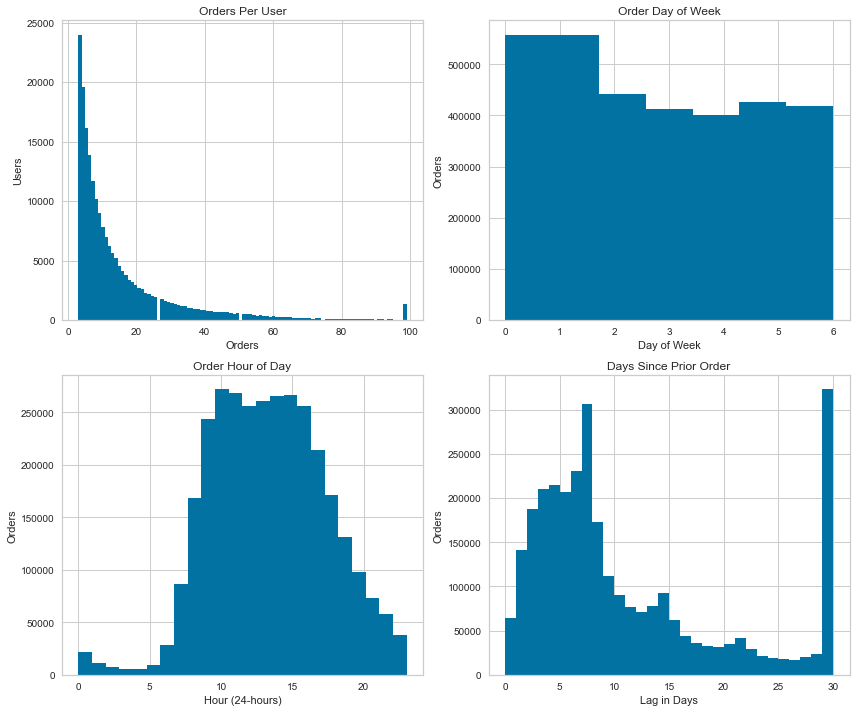

In [310]:
# Plot histograms of features of interest
fig, axes = plt.subplots(2, 2, figsize=(12,10))

ax0 = axes[0,0]
ax0.hist(orders.user_id.value_counts(), bins=100)
ax0.set_title('Orders Per User')
ax0.set_xlabel('Orders')
ax0.set_ylabel('Users')

ax1 = axes[0,1]
ax1.hist(orders.order_dow, bins=7)
ax1.set_title('Order Day of Week')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Orders')

ax2 = axes[1,0]
ax2.hist(orders.order_hour_of_day, bins=24)
ax2.set_title('Order Hour of Day')
ax2.set_xlabel('Hour (24-hours)')
ax2.set_ylabel('Orders')

ax3 = axes[1,1]
ax3.hist(orders.days_since_prior_order, bins=30)
ax3.set_title('Days Since Prior Order')
ax3.set_xlabel('Lag in Days')
ax3.set_ylabel('Orders')

plt.tight_layout()
plt.show();

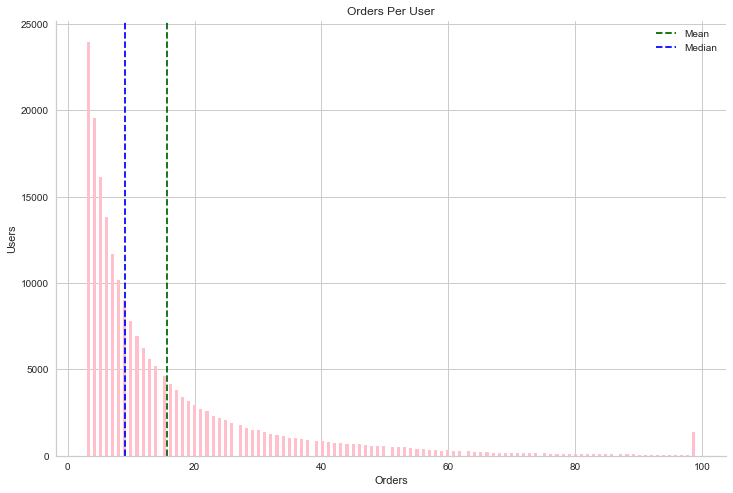

In [314]:
# Visualize orders per customer with mean and median
plt.figure(figsize=(12,8))
plt.hist(orders.user_id.value_counts(), bins=200, color='pink')
plt.axvline(orders.user_id.value_counts().mean(), color='darkgreen', 
            linestyle='--', label='Mean')
plt.axvline(orders.user_id.value_counts().median(), color='blue', 
            linestyle='--', label='Median')
plt.title('Orders Per User')
plt.xlabel('Orders')
plt.ylabel('Users')
plt.legend()
sns.despine()
plt.show();

In [315]:
# Print mean and median
print('Mean orders per customer:', orders.user_id.value_counts().mean())
print('Median orders per customer:', orders.user_id.value_counts().median())

Mean orders per customer: 15.590367054784224
Median orders per customer: 9.0


In [364]:
# Number of unique users/customers
# Count unique users by user_id in orders table
orders.user_id.nunique()

206209

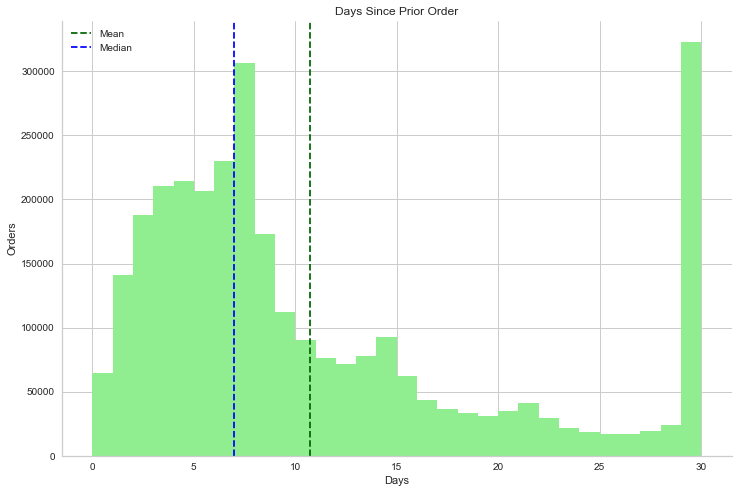

In [320]:
# Visualize days since prior order
plt.figure(figsize=(12,8))
plt.hist(orders.days_since_prior_order, bins=30, color='lightgreen')
plt.axvline(orders.days_since_prior_order.mean(), color='darkgreen', 
            linestyle='--', label='Mean')
plt.axvline(orders.days_since_prior_order.median(), color='blue', 
            linestyle='--', label='Median')
plt.title('Days Since Prior Order')
plt.xlabel('Days')
plt.ylabel('Orders')
plt.legend()
sns.despine()
plt.show();

In [321]:
# Print mean and median of days since prior order
print('Mean lag:', orders.days_since_prior_order.mean())
print('Median lag:', orders.days_since_prior_order.median())

Mean lag: 10.707242248638515
Median lag: 7.0


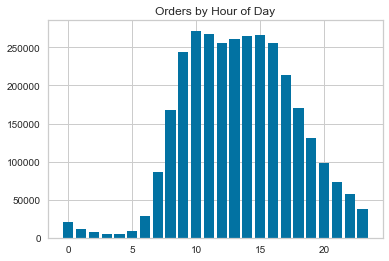

In [365]:
# Busiest shopping time
# Visualize orders by hour of day
plt.bar(orders.order_hour_of_day.value_counts().index, 
        orders.order_hour_of_day.value_counts())
plt.title('Orders by Hour of Day')
plt.show();


In [366]:
# Busiest day of week
# Count orders by day of week: 
orders.order_dow.value_counts()

0    557772
1    556705
2    441955
5    425982
6    418848
3    412400
4    401212
Name: order_dow, dtype: int64

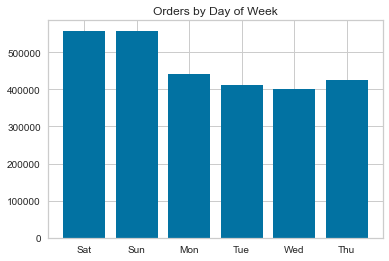

In [367]:
# Busiest day of the week
# Visualize orders by day of week, assuming that 0 = Saturday
days = {0:'Sat', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Sun'}
values = [orders.order_dow.value_counts()[day] for day in days.keys()]
plt.bar(days.values(), values)
plt.title('Orders by Day of Week')
plt.show();

### Baskets Table

In [355]:
baskets.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
3,2,45918,4,1
7,2,1819,8,1
4,2,30035,5,0


In [322]:
baskets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434487
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 1.2 GB


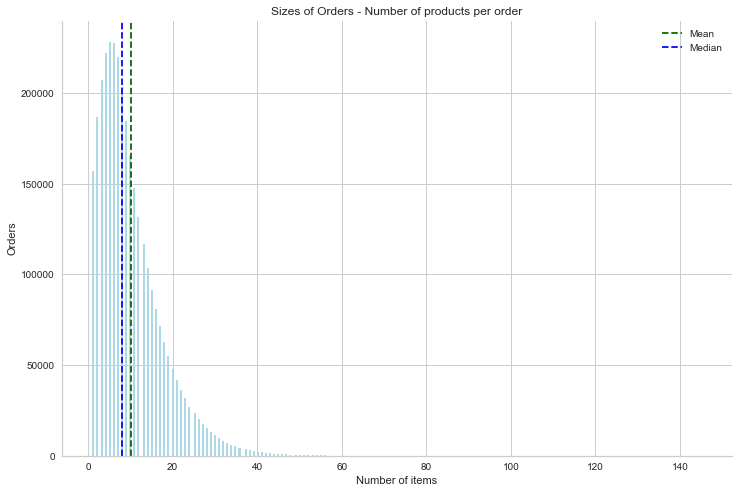

In [339]:
# Plot histogram of products per order
plt.figure(figsize=(12,8))
plt.hist(baskets.order_id.value_counts(), bins=300, color='lightblue')
plt.axvline(baskets.order_id.value_counts().mean(), color='darkgreen', 
            linestyle='--', label='Mean')
plt.axvline(baskets.order_id.value_counts().median(), 
            color='blue', linestyle='--', label='Median')
plt.title('Sizes of Orders - Number of products per order')
plt.xlabel('Number of items')
plt.ylabel('Orders')
plt.legend()
sns.despine()
plt.show();



In [333]:
# Count unique orders
len(baskets.order_id.value_counts())

3214874

### Products Table

In [341]:
prod.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


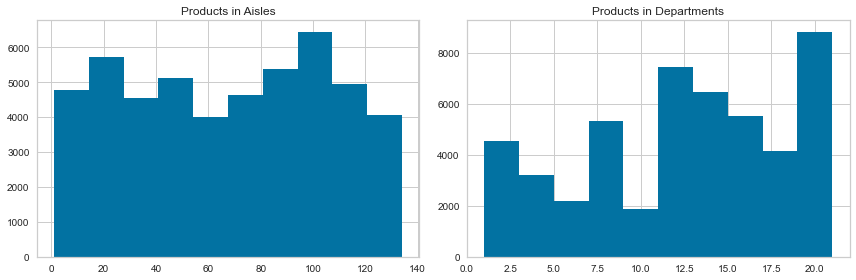

In [369]:
# Plot histograms of counts of products per aisle, department
fig, axes = plt.subplots(1, 2, figsize=(12,4))

ax0 = axes[0]
ax0.hist(prod.aisle_id, bins=10)
ax0.set_title('Products in Aisles')

ax1 = axes[1]
ax1.hist(prod.department_id)
ax1.set_title('Products in Departments')

plt.tight_layout()
plt.show();

In [346]:
# View datatypes and observation counts
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


### Aisles Table

In [348]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [349]:
# View all aisle names
[name for name in aisles.aisle]

['prepared soups salads',
 'specialty cheeses',
 'energy granola bars',
 'instant foods',
 'marinades meat preparation',
 'other',
 'packaged meat',
 'bakery desserts',
 'pasta sauce',
 'kitchen supplies',
 'cold flu allergy',
 'fresh pasta',
 'prepared meals',
 'tofu meat alternatives',
 'packaged seafood',
 'fresh herbs',
 'baking ingredients',
 'bulk dried fruits vegetables',
 'oils vinegars',
 'oral hygiene',
 'packaged cheese',
 'hair care',
 'popcorn jerky',
 'fresh fruits',
 'soap',
 'coffee',
 'beers coolers',
 'red wines',
 'honeys syrups nectars',
 'latino foods',
 'refrigerated',
 'packaged produce',
 'kosher foods',
 'frozen meat seafood',
 'poultry counter',
 'butter',
 'ice cream ice',
 'frozen meals',
 'seafood counter',
 'dog food care',
 'cat food care',
 'frozen vegan vegetarian',
 'buns rolls',
 'eye ear care',
 'candy chocolate',
 'mint gum',
 'vitamins supplements',
 'breakfast bars pastries',
 'packaged poultry',
 'fruit vegetable snacks',
 'preserved dips spreads

In [350]:
# Inspect the "missing" aisle
aisles[aisles['aisle'] == 'missing']

,aisle_id,aisle
99,100,missing


In [351]:
# Inspect datatypes and observation counts
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


### Departments Table

In [353]:
dept.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [368]:
dept.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [358]:
# View all department names
[name for name in dept.department]

['frozen',
 'other',
 'bakery',
 'produce',
 'alcohol',
 'international',
 'beverages',
 'pets',
 'dry goods pasta',
 'bulk',
 'personal care',
 'meat seafood',
 'pantry',
 'breakfast',
 'canned goods',
 'dairy eggs',
 'household',
 'babies',
 'snacks',
 'deli',
 'missing']

From the EDA we get the following information:

    Number of unique users: 206209
    Number of unique orders: 3214874 
    Number of aisles: 134 (one missing aisles for aisle_id=100)
    Number of departments: 21
    Busiest order hours: between 9am and 5pm
    Busiest order days of week are Saturday and Sunday (if 0= Saturday)
    Median lag (days since prior order) : 7 days, mean lag = 10,7 days

## II. Data Preparation

In [336]:
# inner join of basket and products
baskets_prod = pd.merge(baskets, prod, on="product_id", how="inner")
baskets_prod.shape

(32434489, 7)

In [250]:
# inner join of baskets_prod and orders
baskets_prod_orders = pd.merge(baskets_prod, orders, on="order_id", how="inner")
baskets_prod_orders.shape

(32434489, 12)

In [251]:
# left join of baskets_prod_orders and department
baskets_prod_orders_dept = pd.merge(baskets_prod_orders, dept, on="department_id", how="left")
baskets_prod_orders_dept.shape

(32434489, 13)

In [252]:
# left join of baskets_prod_orders_dept and aisles
cust_all = pd.merge(baskets_prod_orders_dept, aisles, on="aisle_id", how="left")
cust_all.shape


(32434489, 14)

In [253]:
cust_all.head(n=10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,3,5,9,8.0,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,3,5,9,8.0,produce,fresh vegetables
2,2,45918,4,1,Coconut Butter,19,13,202279,3,5,9,8.0,pantry,oils vinegars
3,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,202279,3,5,9,8.0,pantry,spreads
4,2,30035,5,0,Natural Sweetener,17,13,202279,3,5,9,8.0,pantry,baking ingredients
5,2,17794,6,1,Carrots,83,4,202279,3,5,9,8.0,produce,fresh vegetables
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,202279,3,5,9,8.0,pantry,doughs gelatins bake mixes
7,2,43668,9,0,Classic Blend Cole Slaw,123,4,202279,3,5,9,8.0,produce,packaged vegetables fruits
8,2,9327,3,0,Garlic Powder,104,13,202279,3,5,9,8.0,pantry,spices seasonings
9,26,33120,5,0,Organic Egg Whites,86,16,153404,2,0,16,7.0,dairy eggs,eggs


## III. Feature Engineering
The dataframe ("cust_all") consists of items (rows) per order per custumer.

We want to create a new dataframe having as rows one customer (user id) and meaningful features:
For each customer features will be:
    
    
    * 1. mean number of products per order: how many products a customer buys in average (basket size)
    * 2. total number of orders of each user: how much customer uses Instacart
    * 3. mean lag between orders: frequency of buying (how often customer uses Instacart)
    * 4. median hour of order
    * 5. mean day of week 
    * 6. reordered_ratio
    


In [254]:
# *1. add column "number of products for each order"
cust_all['nb_products_order'] = cust_all['product_id'].groupby(cust_all['order_id']).transform('count')

In [255]:
cust_all.head(n=10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle,nb_products_order
0,2,33120,1,1,Organic Egg Whites,86,16,202279,3,5,9,8.0,dairy eggs,eggs,9
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,3,5,9,8.0,produce,fresh vegetables,9
2,2,45918,4,1,Coconut Butter,19,13,202279,3,5,9,8.0,pantry,oils vinegars,9
3,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,202279,3,5,9,8.0,pantry,spreads,9
4,2,30035,5,0,Natural Sweetener,17,13,202279,3,5,9,8.0,pantry,baking ingredients,9
5,2,17794,6,1,Carrots,83,4,202279,3,5,9,8.0,produce,fresh vegetables,9
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,202279,3,5,9,8.0,pantry,doughs gelatins bake mixes,9
7,2,43668,9,0,Classic Blend Cole Slaw,123,4,202279,3,5,9,8.0,produce,packaged vegetables fruits,9
8,2,9327,3,0,Garlic Powder,104,13,202279,3,5,9,8.0,pantry,spices seasonings,9
9,26,33120,5,0,Organic Egg Whites,86,16,153404,2,0,16,7.0,dairy eggs,eggs,8


In [256]:
# Group dataframe such that rows are order ids
df_1 = cust_all.groupby(by="order_id").mean()

In [257]:
df_1.head(n=10)

,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,nb_products_order
order_id,,,,,,,,,,,
2,27867.444444,5.0,0.666667,78.666667,10.333333,202279.0,3.0,5.0,9.0,8.0,9.0
3,26582.500000,4.5,1.000000,97.250000,9.375000,205970.0,16.0,5.0,17.0,12.0,8.0
4,29740.615385,7.0,0.923077,59.076923,12.846154,178520.0,36.0,1.0,9.0,7.0,13.0
5,29484.692308,13.5,0.807692,57.846154,11.653846,156122.0,42.0,6.0,16.0,9.0,26.0
6,32744.000000,2.0,0.000000,69.000000,13.666667,22352.0,4.0,1.0,12.0,30.0,3.0
7,40426.000000,1.5,0.000000,73.500000,4.000000,142903.0,11.0,2.0,14.0,30.0,2.0
8,23423.000000,1.0,1.000000,43.000000,3.000000,3107.0,5.0,4.0,6.0,17.0,1.0
9,21635.933333,8.0,0.666667,87.800000,9.666667,139016.0,14.0,0.0,19.0,5.0,15.0
10,22671.133333,8.0,0.533333,62.466667,7.933333,135442.0,4.0,6.0,8.0,8.0,15.0


In [258]:
# Drop unneeded features (no meaning anymore)
df_1 = df_1.drop(columns=["aisle_id","department_id"])

In [259]:
df_1.head()

,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,nb_products_order
order_id,,,,,,,,,
2,27867.444444,5.0,0.666667,202279.0,3.0,5.0,9.0,8.0,9.0
3,26582.500000,4.5,1.000000,205970.0,16.0,5.0,17.0,12.0,8.0
4,29740.615385,7.0,0.923077,178520.0,36.0,1.0,9.0,7.0,13.0
5,29484.692308,13.5,0.807692,156122.0,42.0,6.0,16.0,9.0,26.0
6,32744.000000,2.0,0.000000,22352.0,4.0,1.0,12.0,30.0,3.0


In [260]:
# * 2. Calculate number of orders per user id
df_1['nb_orders_user'] = df_1['nb_products_order'].groupby(df_1['user_id']).transform('count')

In [261]:
# Calculate median ordering hour per user 
median_hour = round(df_1.groupby('user_id')['order_hour_of_day'].median(), 0)
median_hour.head() #series object for later use (grouped by user id)

user_id
1.0     8.0
2.0    10.0
3.0    16.0
4.0    13.0
5.0    17.0
Name: order_hour_of_day, dtype: float64

In [262]:
# create dataframe with user_id as key, aggregating all orders of a user by calculating the mean
df_2 = df_1.groupby(by="user_id").mean()
df_2.head()

,product_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,nb_products_order,nb_orders_user
user_id,,,,,,,,,
1.0,17189.803611,3.450000,0.705833,5.5,2.500000,10.300000,19.555556,5.900000,10
2.0,25507.097335,7.464286,0.447961,7.5,2.142857,10.571429,15.230769,13.928571,14
3.0,27813.333333,4.166667,0.658817,6.5,1.083333,16.416667,12.090909,7.333333,12
4.0,23471.276190,2.300000,0.028571,3.0,4.800000,12.600000,13.750000,3.600000,5
5.0,22770.456692,5.125000,0.377778,2.5,1.750000,16.000000,13.333333,9.250000,4


In [ ]:
# reset index as well as new column "user id" not needed for clustering! 
#df_2["user_id"]=df_2.index
#df_2["user_id"]=df_2["user_id"].astype(int)
#df_2 = df_2.reset_index(drop=True) #not needed for kmeans
#df_2.head()

In [263]:
# Rename columns
df_2 = df_2.rename(columns={"days_since_prior_order": "average_lag_in_days"})
df_2 = df_2.rename(columns={"nb_products_order": "average_item_size_of_orders"})
df_2 = df_2.rename(columns={"nb_orders_user": "total_number_of_orders"})
df_2 = df_2.rename(columns={"order_hour_of_day": "average_order_hour_of_day"})
df_2 = df_2.rename(columns={"order_dow": "average_order_dow"})
df_2 = df_2.rename(columns={"reordered": "reordered_ratio"})
df_2

,product_id,add_to_cart_order,reordered_ratio,order_number,average_order_dow,average_order_hour_of_day,average_lag_in_days,average_item_size_of_orders,total_number_of_orders
user_id,,,,,,,,,
1.0,17189.803611,3.450000,0.705833,5.5,2.500000,10.300000,19.555556,5.900000,10
2.0,25507.097335,7.464286,0.447961,7.5,2.142857,10.571429,15.230769,13.928571,14
3.0,27813.333333,4.166667,0.658817,6.5,1.083333,16.416667,12.090909,7.333333,12
4.0,23471.276190,2.300000,0.028571,3.0,4.800000,12.600000,13.750000,3.600000,5
5.0,22770.456692,5.125000,0.377778,2.5,1.750000,16.000000,13.333333,9.250000,4
...,...,...,...,...,...,...,...,...,...
206205.0,28366.204482,5.833333,0.369048,2.0,3.666667,14.333333,20.000000,10.666667,3
206206.0,29294.680325,2.626866,0.570676,34.0,2.477612,16.731343,3.772727,4.253731,67
206207.0,26865.592900,7.468750,0.637144,8.5,2.562500,12.500000,14.333333,13.937500,16


In [264]:
# Drop unnecessary columns
df_2 = df_2.drop(columns=["add_to_cart_order"])
df_2 = df_2.drop(columns=["order_number"])
df_2 = df_2.drop(columns=["product_id"])

In [265]:
df_2

,reordered_ratio,average_order_dow,average_order_hour_of_day,average_lag_in_days,average_item_size_of_orders,total_number_of_orders
user_id,,,,,,
1.0,0.705833,2.500000,10.300000,19.555556,5.900000,10
2.0,0.447961,2.142857,10.571429,15.230769,13.928571,14
3.0,0.658817,1.083333,16.416667,12.090909,7.333333,12
4.0,0.028571,4.800000,12.600000,13.750000,3.600000,5
5.0,0.377778,1.750000,16.000000,13.333333,9.250000,4
...,...,...,...,...,...,...
206205.0,0.369048,3.666667,14.333333,20.000000,10.666667,3
206206.0,0.570676,2.477612,16.731343,3.772727,4.253731,67
206207.0,0.637144,2.562500,12.500000,14.333333,13.937500,16


In [266]:
# Add median hour and median hour of day to dataframe
# Concatenate new features into one DataFrame
df_XY = pd.concat([df_2,median_hour], axis=1)
df_XY.head()

,reordered_ratio,average_order_dow,average_order_hour_of_day,average_lag_in_days,average_item_size_of_orders,total_number_of_orders,order_hour_of_day
user_id,,,,,,,
1.0,0.705833,2.500000,10.300000,19.555556,5.900000,10,8.0
2.0,0.447961,2.142857,10.571429,15.230769,13.928571,14,10.0
3.0,0.658817,1.083333,16.416667,12.090909,7.333333,12,16.0
4.0,0.028571,4.800000,12.600000,13.750000,3.600000,5,13.0
5.0,0.377778,1.750000,16.000000,13.333333,9.250000,4,17.0


In [267]:
# Rename the columns order hour and dow
df_XY = df_XY.rename(columns={"order_hour_of_day": "median_hour"})

In [268]:
# Drop average_order_hour_of_day (keep median)
df_XY = df_XY.drop(columns=["average_order_hour_of_day"])

In [269]:
df_XY.head()

,reordered_ratio,average_order_dow,average_lag_in_days,average_item_size_of_orders,total_number_of_orders,median_hour
user_id,,,,,,
1.0,0.705833,2.500000,19.555556,5.900000,10,8.0
2.0,0.447961,2.142857,15.230769,13.928571,14,10.0
3.0,0.658817,1.083333,12.090909,7.333333,12,16.0
4.0,0.028571,4.800000,13.750000,3.600000,5,13.0
5.0,0.377778,1.750000,13.333333,9.250000,4,17.0


In [270]:
df_k=df_XY.copy()

In [271]:
df_k.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 206209 entries, 1.0 to 206209.0
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   reordered_ratio              206209 non-null  float64
 1   average_order_dow            206209 non-null  float64
 2   average_lag_in_days          206209 non-null  float64
 3   average_item_size_of_orders  206209 non-null  float64
 4   total_number_of_orders       206209 non-null  int64  
 5   median_hour                  206209 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 11.0 MB


## IV. Kmeans Clustering 

### IV.1. Data-Preprocessing

#### IV.1.1. Check for missing values and skewness
We need to think of missing values and skewness before using clustering algorithms for segmentation.
No missing values allowed, distribution should be approximately normal otherwise k-means is not working properly. The data should meet assumptions where the variables are not skewed and have the same mean and variance.

In [272]:
# Check for missing values
df_k.isna().sum()

reordered_ratio                0
average_order_dow              0
average_lag_in_days            0
average_item_size_of_orders    0
total_number_of_orders         0
median_hour                    0
dtype: int64

In [273]:
#save dataframe for later use
df_new=df_k.copy()

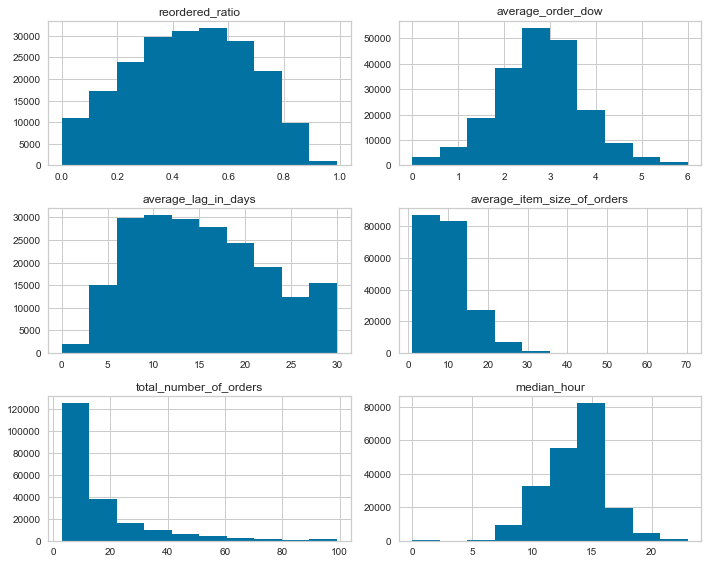

In [274]:
# Check for skewness
# Visualize distribution of each feature
df_k.hist(figsize=(10,8))
plt.tight_layout();

As we can see from above, two variables show a positive right skew: average_item_size_of_orders and total_number_of_orders. We have to transform the data, so it has a more symmetrical form. Also we will have a closer look to average_lag_in_days. 

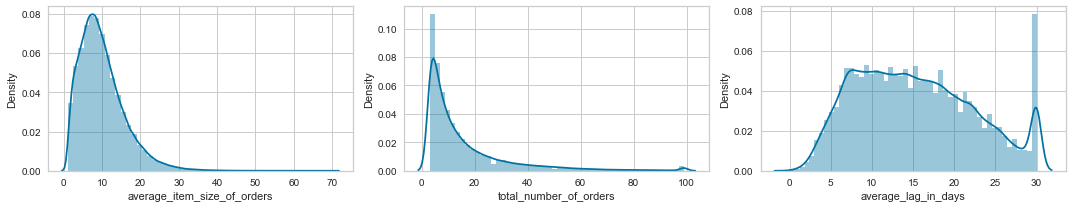

In [276]:
# plot only those three features again with density plot:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(df_k['average_item_size_of_orders'], ax=ax[0])
sns.distplot(df_k['total_number_of_orders'], ax=ax[1])
sns.distplot(df_k['average_lag_in_days'], ax=ax[2])
plt.tight_layout()
plt.show()

In [277]:
# Define a function to calculate skewness scores
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(df_k[x], ax=ax[0,0])
    sns.distplot(np.log(df_k[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df_k[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df_k[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    # print skewness parameter
    print(df_k[x].skew().round(2)) #general skewness, not transformed data
    print(np.log(df_k[x]).skew().round(2))
    print(np.sqrt(df_k[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_k[x])[0]).skew().round(2))

Here is how to interpret the skewness value: If the value is close to 0, the variable tend to have symmetrical form. However, if it’s not, the variable has skew on it. So the transformation type is chosen where the skewness score is closer to zero.

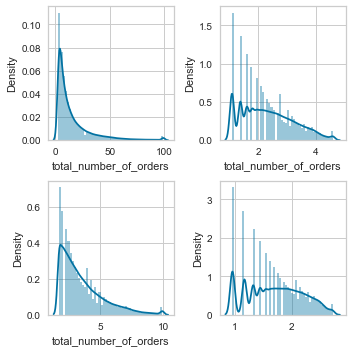

2.4
0.44
1.32
0.07


In [281]:
# analyze skewness of individual variables
analyze_skewness('total_number_of_orders')

Below are the visualization of each variable: without and with transformations.
From top left clockwise on each variable shows the plot without transformation, log transformation, square root transformation, and box-cox transformation.

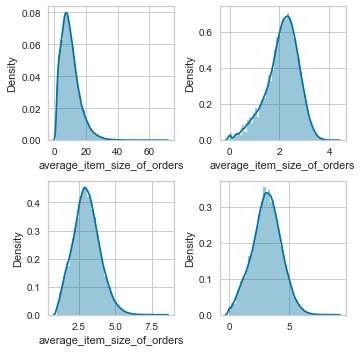

1.23
-0.58
0.32
-0.01


In [280]:
analyze_skewness('average_item_size_of_orders')

In [294]:
# Function for skewness for average_lag_in_days (due to a lot of zeros log+1 and without box-cox)
# Boxcox transformation is not possible on this feature because of zero values which mean something (zeros cannot be excluded)
from scipy import stats
def analyze_skewness_2(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(df_k[x], ax=ax[0,0])
    sns.distplot(np.log(df_k[x]+1), ax=ax[0,1])
    sns.distplot(np.sqrt(df_k[x]), ax=ax[1,0])
    plt.tight_layout()
    plt.show()


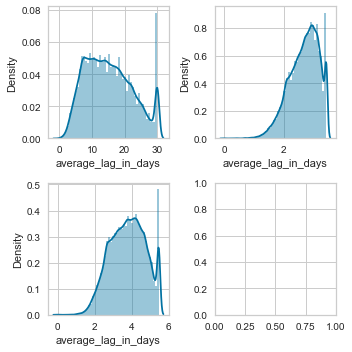

In [295]:
analyze_skewness_2('average_lag_in_days')

In [91]:
# skew without transformation for "average__lag_in_days"
print(df_k["average_lag_in_days"].skew().round(2))


0.34


In [70]:
# Log+1 transformation for "average__lag_in_days"
print(np.log(df_k["average_lag_in_days"]+1).skew().round(2))

-0.61


In [72]:
# sqrt tansformation for "average__lag_in_days"
print(np.sqrt(df_k["average_lag_in_days"]).skew().round(2))
 

-0.13


In [296]:
df_k.describe()

,reordered_ratio,average_order_dow,average_lag_in_days,average_item_size_of_orders,total_number_of_orders,median_hour
count,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000
mean,0.457151,2.753258,15.209435,9.951586,15.590367,13.590740
std,0.215915,0.941419,7.105277,5.863570,16.654774,2.647454
min,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
25%,0.294452,2.200000,9.416667,5.740741,5.000000,12.000000
50%,0.463889,2.750000,14.500000,8.933333,9.000000,14.000000
75%,0.626410,3.333333,20.285714,13.000000,19.000000,15.000000
max,0.989899,6.000000,30.000000,70.250000,99.000000,23.000000


#### IV.1.2. Manage Skewness  

We will use box-cox transformation for 2 features (total_number_of_orders; average_item_size_of_orders) and use sqrt transformation for average_lag_in_days (since the resulting skewness values are near 0).


In [297]:
# Save dataset for later use
df_k2=df_k.copy()

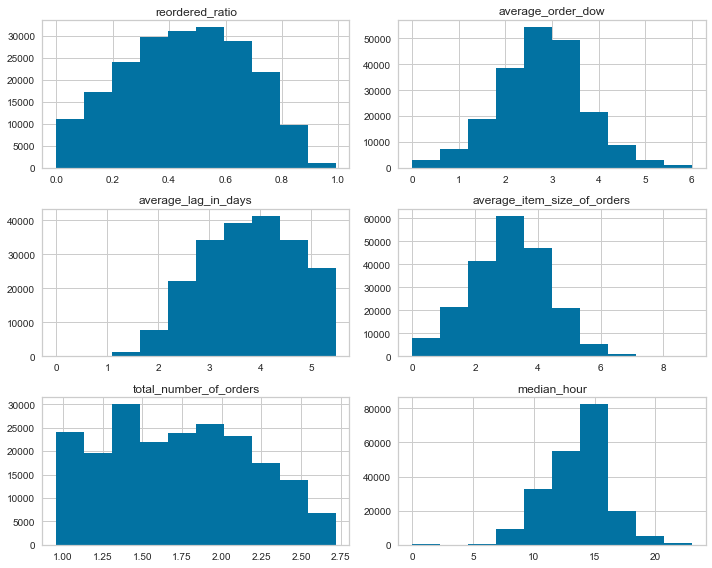

In [298]:
# Transform three columns and replot features
df_k2['total_number_of_orders'] = stats.boxcox(df_k2['total_number_of_orders'])[0]
df_k2['average_item_size_of_orders'] = stats.boxcox(df_k2['average_item_size_of_orders'])[0]
df_k2['average_lag_in_days'] = np.sqrt(df_k2["average_lag_in_days"])
df_k2.hist(figsize=(10,8))
plt.tight_layout();






In [96]:
df_k2.head()

,reordered_ratio,average_order_dow,average_lag_in_days,average_item_size_of_orders,total_number_of_orders,median_order_hour
user_id,,,,,,
1.0,0.705833,2.500000,4.422166,2.374472,1.744875,8.0
2.0,0.447961,2.142857,3.902662,4.093757,1.924935,10.0
3.0,0.658817,1.083333,3.477198,2.767018,1.844344,16.0
4.0,0.028571,4.800000,3.708099,1.576208,1.321894,13.0
5.0,0.377778,1.750000,3.651484,3.216734,1.169153,17.0


#### IV.1.3. Centuring and scaling variables

The distributions now look good. Next step: Standardization (so the features have mean = 0 and standard deviation = 1).
K-means is easily influenced by outliers, and standardization helps mitigate that.

In [97]:
# load neccessary packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

In [98]:
# Scale all of the features
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(df_k2)

In [100]:
# Convert to DataFrame and check summary stats
df_k2_sc = pd.DataFrame(feature_scaled)
df_k2_sc.describe()

,0,1,2,3,4,5
count,2.062090e+05,2.062090e+05,2.062090e+05,2.062090e+05,2.062090e+05,2.062090e+05
mean,-1.607325e-16,-9.535438e-16,-7.412168e-16,4.967524e-16,9.454194e-16,-6.120672e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.117277e+00,-2.924589e+00,-4.009000e+00,-2.574191e+00,-1.571937e+00,-5.133526e+00
25%,-7.535334e-01,-5.876864e-01,-7.578630e-01,-6.546100e-01,-8.101522e-01,-6.008582e-01
50%,3.120579e-02,-3.460694e-03,2.532317e-02,2.201339e-02,-4.722689e-02,1.545865e-01
75%,7.839170e-01,6.161727e-01,7.627957e-01,6.743498e-01,7.723005e-01,5.323088e-01
max,2.467400e+00,3.448782e+00,1.793930e+00,4.772095e+00,2.116510e+00,3.554087e+00


In [101]:
# Check if mean = 0 and standard deviation = 1
print(df_k2_sc.mean(axis = 0).round(2))
print(df_k2_sc.std(axis = 0).round(2))

0   -0.0
1   -0.0
2   -0.0
3    0.0
4    0.0
5   -0.0
dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
dtype: float64


## IV.2. KMEANS - Find optimal number of k

Parameter Tuning: 
By testing a bunch of values for k, we can get a clearer idea of how many clusters are actually a good fit for our data. We used two metrics: distortion score and silhouette score with Elbow plot. Distortion score is a measure of intra-cluster similarity, and silhouette measures inter-cluster similarity. Furthermore TSNE plot is used to distinguish clusters better. 
Determine best value for k with:

    - elbow plot with silhouette score
    - elbow plot with distorsion score
    - TSNE plot to inspect clusters for separability
At first the full feature set will be analyzed, in a second step we well concentrate on only the first three features: mean lag, total number of orders and mean number of product per order.


### *FULL FEATURE SET: 6 features

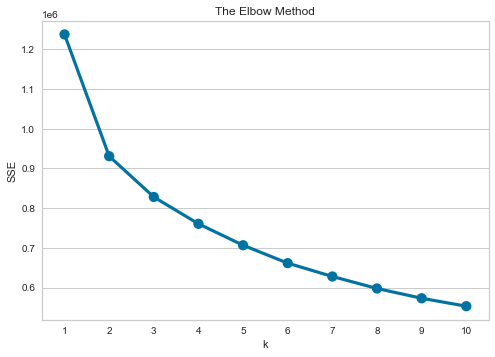

In [103]:
# Elbow Plot with silhouette score
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_k2_sc)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

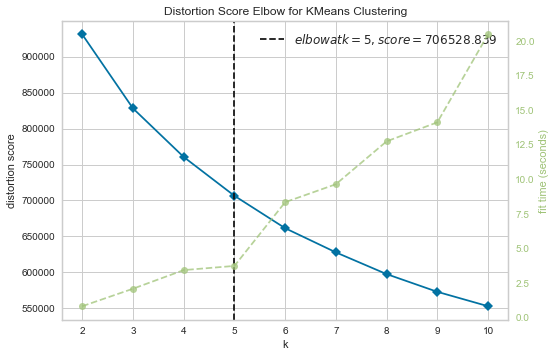

In [112]:
# Visualize performance of KMeans at various values k
# This approaches uses distortion score to evaluate KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 11))

visualizer.fit(df_k2_sc)   
visualizer.show();



The elbow plot with the silhouette score shows k=3 is the optimal k, the distortion score elbow shows k=5.
In a next step we will visualize with the help of tsne plots k=3, k=4 and k=5.

In [ ]:
# Visualize clusters with tsne

# Define a function to calculate and plot specified # of clusters
def kmeans(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        end : int. Ending range of kmeans to test.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''   
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new, cluster_labels

(               0         1         2         3         4         5  Cluster
 0       1.151762 -0.269018  0.676131 -0.615406  0.077928 -2.111747        2
 1      -0.042564 -0.648385  0.125734  0.802892  0.455976 -1.356303        2
 2       0.934009 -1.773842 -0.325029 -0.291582  0.286770  0.910031        2
 3      -1.984950  2.174108 -0.080398 -1.273922 -0.810152 -0.223136        0
 4      -0.367614 -1.065689 -0.140380  0.079405 -1.130841  1.287753        1
 ...          ...       ...       ...       ...       ...       ...      ...
 206204 -0.408048  0.970249  0.729072  0.320820 -1.571937  0.532309        0
 206205  0.525788 -0.292799 -1.951147 -1.062800  1.847305  1.287753        2
 206206  0.833628 -0.202629  0.002070  0.804099  0.597306 -0.600858        2
 206207  1.126447 -0.106432 -1.119650  0.787673  1.611523  0.532309        2
 206208  0.368669  0.016967  0.423061  0.197053  0.375454 -0.223136        2
 
 [206209 rows x 7 columns],
 array([2, 2, 2, ..., 2, 2, 2]))

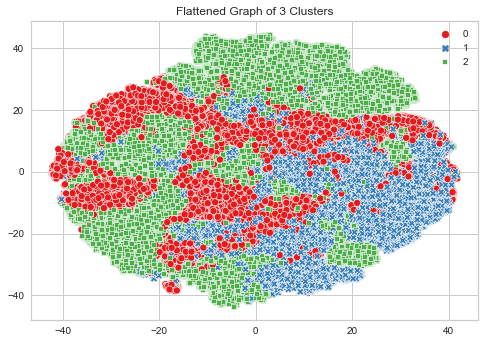

In [118]:
# Visualize clusters with tsne (k=3)
kmeans(df_k2_sc, 3)

(               0         1         2         3         4         5  Cluster
 0       1.151762 -0.269018  0.676131 -0.615406  0.077928 -2.111747        2
 1      -0.042564 -0.648385  0.125734  0.802892  0.455976 -1.356303        1
 2       0.934009 -1.773842 -0.325029 -0.291582  0.286770  0.910031        1
 3      -1.984950  2.174108 -0.080398 -1.273922 -0.810152 -0.223136        0
 4      -0.367614 -1.065689 -0.140380  0.079405 -1.130841  1.287753        3
 ...          ...       ...       ...       ...       ...       ...      ...
 206204 -0.408048  0.970249  0.729072  0.320820 -1.571937  0.532309        0
 206205  0.525788 -0.292799 -1.951147 -1.062800  1.847305  1.287753        1
 206206  0.833628 -0.202629  0.002070  0.804099  0.597306 -0.600858        1
 206207  1.126447 -0.106432 -1.119650  0.787673  1.611523  0.532309        1
 206208  0.368669  0.016967  0.423061  0.197053  0.375454 -0.223136        1
 
 [206209 rows x 7 columns],
 array([2, 1, 1, ..., 1, 1, 1]))

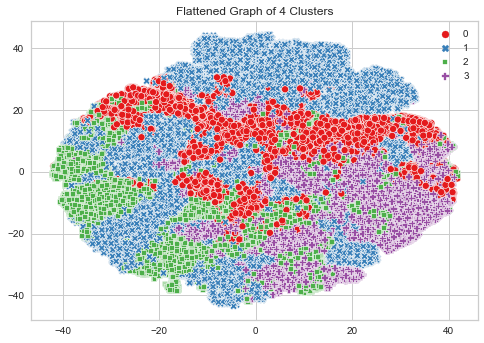

In [116]:
# Visualize clusters with tsne (k=4)
kmeans(df_k2_sc, 4)

(               0         1         2         3         4         5  Cluster
 0       1.151762 -0.269018  0.676131 -0.615406  0.077928 -2.111747        0
 1      -0.042564 -0.648385  0.125734  0.802892  0.455976 -1.356303        4
 2       0.934009 -1.773842 -0.325029 -0.291582  0.286770  0.910031        4
 3      -1.984950  2.174108 -0.080398 -1.273922 -0.810152 -0.223136        2
 4      -0.367614 -1.065689 -0.140380  0.079405 -1.130841  1.287753        1
 ...          ...       ...       ...       ...       ...       ...      ...
 206204 -0.408048  0.970249  0.729072  0.320820 -1.571937  0.532309        2
 206205  0.525788 -0.292799 -1.951147 -1.062800  1.847305  1.287753        3
 206206  0.833628 -0.202629  0.002070  0.804099  0.597306 -0.600858        4
 206207  1.126447 -0.106432 -1.119650  0.787673  1.611523  0.532309        3
 206208  0.368669  0.016967  0.423061  0.197053  0.375454 -0.223136        4
 
 [206209 rows x 7 columns],
 array([0, 4, 4, ..., 4, 3, 4]))

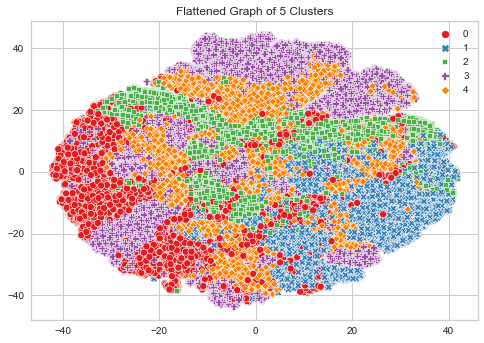

In [117]:
## Visualize clusters with tsne (k=5)
kmeans (df_k2_sc, 5)

The TSNE plots show that k=3 and k=4 would be best. k=5 does not distinguish the clusters very well.

### *SECOND FEATURE SET: 3 features
This time the number of features is reduced to three (average lag in days, total number of orders and average item size). The df_k2 dataframe is reduced by unwanted features. Again a scaling needs to be performed (standard scaler) to get correct values for k-means clustering. 

In [119]:
df_k2.head()

,reordered_ratio,average_order_dow,average_lag_in_days,average_item_size_of_orders,total_number_of_orders,median_order_hour
user_id,,,,,,
1.0,0.705833,2.500000,4.422166,2.374472,1.744875,8.0
2.0,0.447961,2.142857,3.902662,4.093757,1.924935,10.0
3.0,0.658817,1.083333,3.477198,2.767018,1.844344,16.0
4.0,0.028571,4.800000,3.708099,1.576208,1.321894,13.0
5.0,0.377778,1.750000,3.651484,3.216734,1.169153,17.0


In [120]:
# Only select 3 features - standardization and create new dataframe
# Drop unwanted features
df_k2_fewer = df_k2.drop(['reordered_ratio', 'average_order_dow', 'median_order_hour'], axis=1)

df_k2_fewer.head()

,average_lag_in_days,average_item_size_of_orders,total_number_of_orders
user_id,,,
1.0,4.422166,2.374472,1.744875
2.0,3.902662,4.093757,1.924935
3.0,3.477198,2.767018,1.844344
4.0,3.708099,1.576208,1.321894
5.0,3.651484,3.216734,1.169153


In [121]:
# Scale selected features
scaler = StandardScaler()
df_k2_few_sc = scaler.fit_transform(df_k2_fewer)

# Convert to DataFrame
df_k2_few_sc = pd.DataFrame(df_k2_few_sc)

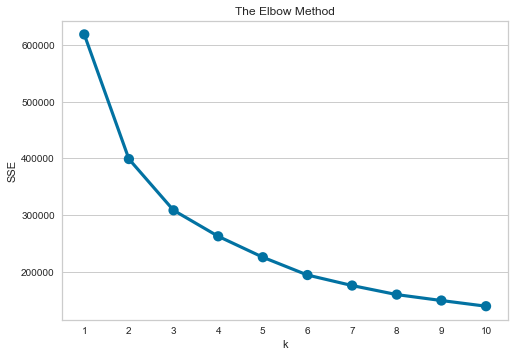

In [122]:
# Choose optimal number of k
# 1. Elbow Plot with silhouette score
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_k2_few_sc)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

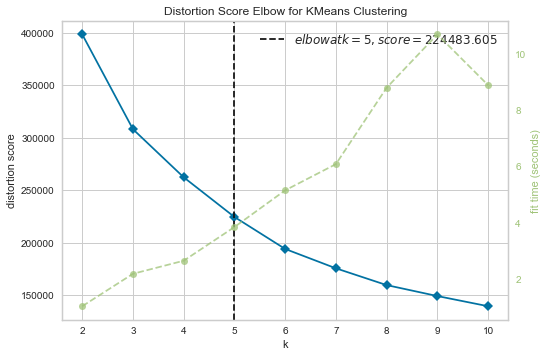

In [123]:
# 2. Distortion score elbow plot
# This approaches uses distortion score to evaluate KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 11))

visualizer.fit(df_k2_few_sc)   
visualizer.show();


Again we will visualize k=3, k=4, k=5.

In [ ]:
# Define a function to calculate and plot specified # of clusters
def kmeans(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        end : int. Ending range of kmeans to test.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''   
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new, cluster_labels

(               0         1         2  Cluster
 0       0.676131 -0.615406  0.077928        2
 1       0.125734  0.802892  0.455976        1
 2      -0.325029 -0.291582  0.286770        0
 3      -0.080398 -1.273922 -0.810152        2
 4      -0.140380  0.079405 -1.130841        1
 ...          ...       ...       ...      ...
 206204  0.729072  0.320820 -1.571937        1
 206205 -1.951147 -1.062800  1.847305        0
 206206  0.002070  0.804099  0.597306        1
 206207 -1.119650  0.787673  1.611523        0
 206208  0.423061  0.197053  0.375454        1
 
 [206209 rows x 4 columns],
 array([2, 1, 0, ..., 1, 0, 1]))

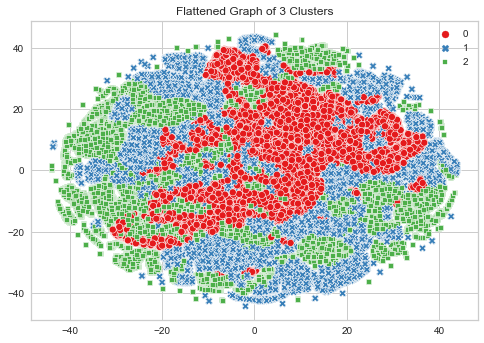

In [126]:
# 3. TSNE plot 
# Visualize clusters with k=3
kmeans (df_k2_few_sc, 3)

(               0         1         2  Cluster
 0       0.676131 -0.615406  0.077928        3
 1       0.125734  0.802892  0.455976        2
 2      -0.325029 -0.291582  0.286770        1
 3      -0.080398 -1.273922 -0.810152        1
 4      -0.140380  0.079405 -1.130841        2
 ...          ...       ...       ...      ...
 206204  0.729072  0.320820 -1.571937        3
 206205 -1.951147 -1.062800  1.847305        0
 206206  0.002070  0.804099  0.597306        2
 206207 -1.119650  0.787673  1.611523        0
 206208  0.423061  0.197053  0.375454        2
 
 [206209 rows x 4 columns],
 array([3, 2, 1, ..., 2, 0, 2]))

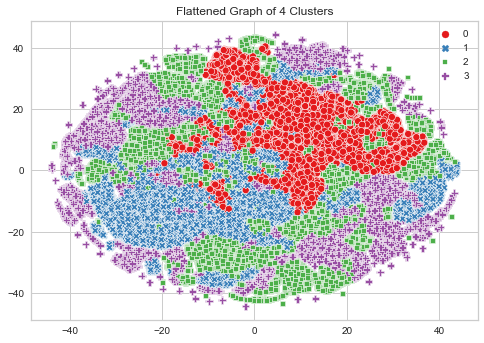

In [127]:
# Visualize clusters with k=4
kmeans (df_k2_few_sc, 4)

(               0         1         2  Cluster
 0       0.676131 -0.615406  0.077928        3
 1       0.125734  0.802892  0.455976        4
 2      -0.325029 -0.291582  0.286770        0
 3      -0.080398 -1.273922 -0.810152        3
 4      -0.140380  0.079405 -1.130841        1
 ...          ...       ...       ...      ...
 206204  0.729072  0.320820 -1.571937        2
 206205 -1.951147 -1.062800  1.847305        0
 206206  0.002070  0.804099  0.597306        4
 206207 -1.119650  0.787673  1.611523        0
 206208  0.423061  0.197053  0.375454        4
 
 [206209 rows x 4 columns],
 array([3, 4, 0, ..., 4, 0, 4]))

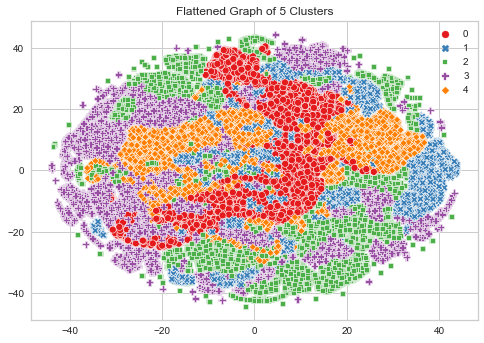

In [128]:
# Visualize clusters with k=5
kmeans (df_k2_few_sc, 5)

In the small feature set (of three features) the optimal number of k points to three! And the TSNE plot looks smoother for 3 features than for the whole feature set.
So we choose 3 features with 3 clusters for the clustering part.

## IV.3. Kmeans Clustering and Snake Plot creation

### *3 FEATURES SET with k=3

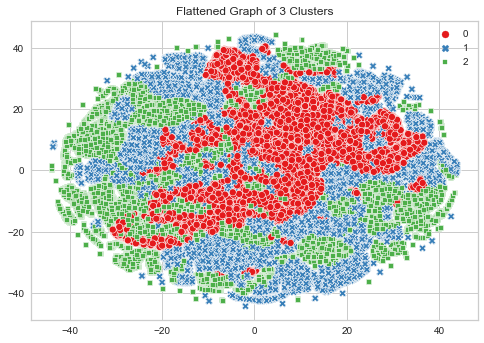

In [219]:
# Compute kmeans and stor result with k=3
k3 = kmeans(df_k2_few_sc, 3) 

In [300]:
# look at column names and index
df_k2_fewer.head()

,average_lag_in_days,average_item_size_of_orders,total_number_of_orders
user_id,,,
1.0,4.422166,2.374472,1.744875
2.0,3.902662,4.093757,1.924935
3.0,3.477198,2.767018,1.844344
4.0,3.708099,1.576208,1.321894
5.0,3.651484,3.216734,1.169153


In [301]:
# Convert clusters to DataFrame with appropriate index and column names k=3
cluster_df_3 = pd.DataFrame(k3[0])
cluster_df_3.index = df_k2_fewer.index
cluster_df_3.columns = ['average_lag_in_days', 'average_item_size_of_orders', 
                      'total_number_of_orders', 'Cluster']
cluster_df_3.head()

,average_lag_in_days,average_item_size_of_orders,total_number_of_orders,Cluster
user_id,,,,
1.0,0.676131,-0.615406,0.077928,2
2.0,0.125734,0.802892,0.455976,1
3.0,-0.325029,-0.291582,0.286770,0
4.0,-0.080398,-1.273922,-0.810152,2
5.0,-0.140380,0.079405,-1.130841,1


In [302]:
# Create summary table of clusters (mean for each cluster)
cluster_df_3.groupby('Cluster').agg({
    'average_lag_in_days':'mean',
    'average_item_size_of_orders':'mean',
    'total_number_of_orders':['mean', 'count']}).round(1)

average_lag_in_days average_item_size_of_orders  \
                       mean                        mean   
Cluster                                                   
0                      -0.9                         0.0   
1                       0.5                         0.8   
2                       0.6                        -1.0   

        total_number_of_orders         
                          mean  count  
Cluster                                
0                          0.9  77756  
1                         -0.5  67254  
2                         -0.6  61199

In [303]:
# Reshape data for snake plot
cluster_melt3 = pd.melt(cluster_df_3.reset_index(),
                       id_vars=['user_id', 'Cluster'],
                       value_vars=['average_lag_in_days', 
                                   'average_item_size_of_orders', 
                                   'total_number_of_orders'],
                       var_name='Metric',
                       value_name='Value')

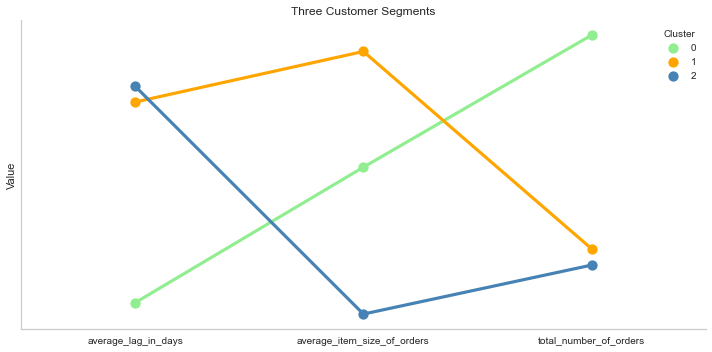

In [304]:
# Create snake plot
palette = ['lightgreen', 'orange', 'steelblue']
plt.figure(figsize=(10,5))
sns.pointplot(x='Metric', y='Value', data=cluster_melt3, hue='Cluster', 
              palette=palette)
plt.xlabel('')
plt.ylabel('Value')
plt.yticks([])
plt.title('Three Customer Segments')
sns.despine()
plt.tight_layout()
plt.savefig('snake_plot.png', dpi=300, pad_inches=2.0)
plt.show();

#remember values are still standardized!

In [215]:
# Reshape data for snake plot (New order of features)
cluster_melt_new_3 = pd.melt(cluster_df_3.reset_index(),
                       id_vars=['user_id', 'Cluster'],
                       value_vars=['total_number_of_orders', 
                                   'average_lag_in_days', 
                                   'average_item_size_of_orders'],
                       var_name='Metric',
                       value_name='Value')

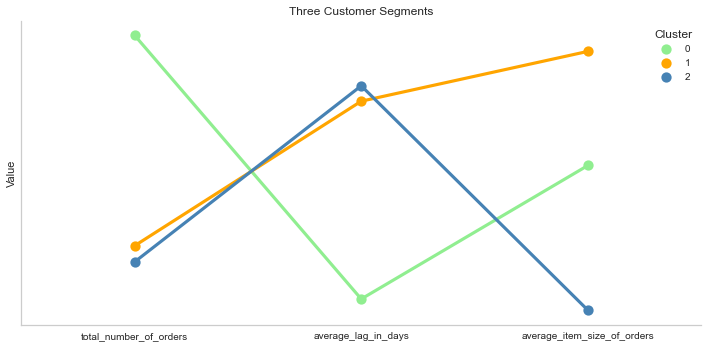

In [216]:
# Create snake plot
palette = ['lightgreen', 'orange', 'steelblue']
plt.figure(figsize=(10,5))
sns.pointplot(x='Metric', y='Value', data=cluster_melt_new_3, hue='Cluster', 
              palette=palette)
plt.xlabel('')
plt.ylabel('Value')
plt.yticks([])
plt.title('Three Customer Segments')
sns.despine()
plt.tight_layout()
plt.savefig('snake_plot.png', dpi=300, pad_inches=2.0)
plt.show();



We habe three distinct customer segments:

Cluster 0 (green): high total number of orders, very low average lag, medium item size at each order --> loyal customer!

Cluster 1 (orange): low number of orders, high lag in days, very high item size per order --> bulk buyers (families, firms)

Cluster 2 (blue): low number of orders, high lag in day, very low item size --> marketing measures to take!